### RNN with Attention (Possible solution)

In [2]:
# -*- coding: utf-8 -*-
"""
Wind Turbine Power Prediction with RNNs + Attention

This lab uses an Attention-enhanced Recurrent Neural Network to predict wind turbine power output.
"""

# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# load the data
df = pd.read_csv('T1.csv')

# display basic info
print(df.shape)
print(df.head())

(50530, 5)
          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  


In [3]:
# Step 1: Prepare the Data
# convert date/time column to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')

# check date/time column format
print(df.head())

            Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:00:00           380.047791          5.311336   
1 2018-01-01 00:10:00           453.769196          5.672167   
2 2018-01-01 00:20:00           306.376587          5.216037   
3 2018-01-01 00:30:00           419.645905          5.659674   
4 2018-01-01 00:40:00           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  


In [4]:
# check for nulls
print(df.isnull().sum())

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64


In [5]:
# get summary statistics
print(df.describe())

                           Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
count                          50530         50530.000000      50530.000000   
mean   2018-07-01 20:01:30.065307648          1307.684332          7.557952   
min              2018-01-01 00:00:00            -2.471405          0.000000   
25%              2018-04-03 05:22:30            50.677890          4.201395   
50%              2018-06-30 16:15:00           825.838074          7.104594   
75%              2018-09-26 18:57:30          2482.507568         10.300020   
max              2018-12-31 23:50:00          3618.732910         25.206011   
std                              NaN          1312.459242          4.227166   

       Theoretical_Power_Curve (KWh)  Wind Direction (°)  
count                   50530.000000        50530.000000  
mean                     1492.175463          123.687559  
min                         0.000000            0.000000  
25%                       161.328167           49.31

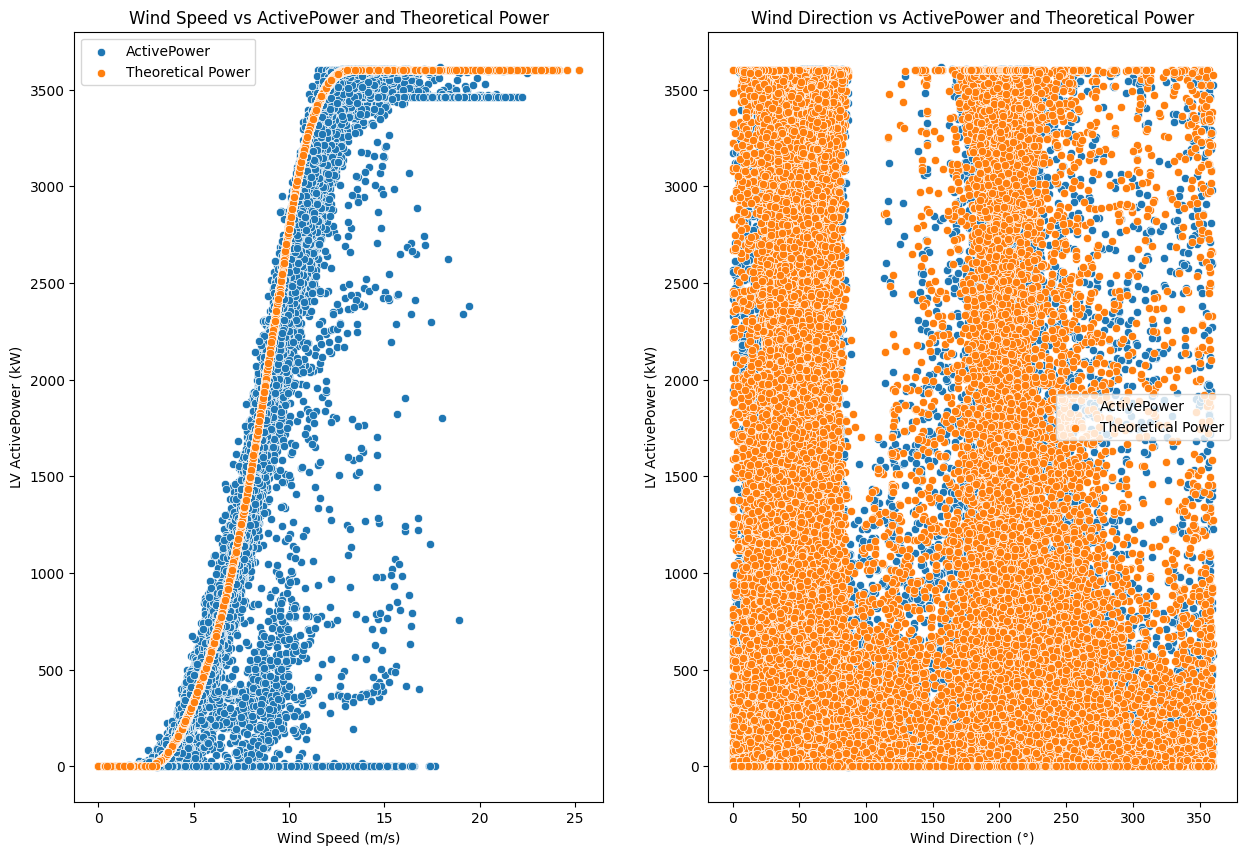

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

sns.scatterplot(data=df, x='Wind Speed (m/s)', y='LV ActivePower (kW)', label='ActivePower', ax=axes[0])
sns.scatterplot(data=df, x='Wind Speed (m/s)', y='Theoretical_Power_Curve (KWh)', label='Theoretical Power', ax=axes[0])
axes[0].set_title('Wind Speed vs ActivePower and Theoretical Power')

sns.scatterplot(data=df, x='Wind Direction (°)', y='LV ActivePower (kW)', label='ActivePower', ax=axes[1])
sns.scatterplot(data=df, x='Wind Direction (°)', y='Theoretical_Power_Curve (KWh)', label='Theoretical Power', ax=axes[1])
axes[1].set_title('Wind Direction vs ActivePower and Theoretical Power')

axes[0].legend()
axes[1].legend()
plt.show()

In [7]:
# normalize columns in new df
from sklearn.preprocessing import MinMaxScaler

# Features and target
features = ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)']
target = ['LV ActivePower (kW)']

# Fit scalers separately
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[target])

# Combine for sequence creation
scaled_data = np.hstack([y_scaled, X_scaled])  # target first, then features

print(scaled_data)

[[0.10563314 0.21071704 0.11564692]
 [0.1259914  0.22503231 0.14442153]
 [0.08528875 0.20693623 0.10858334]
 ...
 [0.60852085 0.33465661 0.49674577]
 [0.69539448 0.37377457 0.67177292]
 [0.77955763 0.3959108  0.77199558]]


In [8]:
# Step 2: Create sequences
def create_sequences(dataset, seq_length):
  X = []
  y = []
  for i in range(len(dataset) - seq_length):
    X.append(dataset[i: i+seq_length])
    y.append(dataset[i+seq_length])

  X = np.array(X)
  y = np.array(y)

  print(X.shape, y.shape)
  return X, y

seq_length = 24

X, y = create_sequences(scaled_data, seq_length)

# Only keep the target column (first column) from y
y = y[:, 0].reshape(-1, 1)



(50506, 24, 3) (50506, 3)


In [9]:
# Step 3: Split the data
train_size = int(len(X) * 0.8)

# split into train and test sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# check sizes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



(40404, 24, 3) (10102, 24, 3) (40404, 1) (10102, 1)


In [10]:
# Step 4: Define a Custom Attention Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable weights for computing attention scores
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute alignment scores using tanh activation
        score = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        # Normalize scores to get attention weights
        attention_weights = tf.nn.softmax(score, axis=1)
        # Compute the context vector as a weighted sum of inputs
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights



In [24]:
from sklearn.model_selection import train_test_split

# Step 5: Build the RNN Model with Attention
# define the input layer with shape (seq_length, 1)
input_seq = Input(shape=(seq_length, 3))

# add LSTM layer that outputs the full sequence
lstm_1 = LSTM(50, return_sequences=True)(input_seq)

# add dropout layer to reduce overfitting
dropout_1 = Dropout(0.2)(lstm_1)

# LSTM layer 2
lstm_2 = LSTM(50, return_sequences=True)(dropout_1)

# add dropout layer 2
dropout_2 = Dropout(0.2)(lstm_2)

# apply custom attention layer
context_vector, attention_weights = AttentionLayer(name='attention_layer')(dropout_2)

# dense output layer
output = Dense(1, activation='linear')(context_vector)

# create the Model
model = Model(inputs=input_seq, outputs=output)

model.summary()

# Step 6: Compile and Train the Model
model.compile(optimizer='adam', loss='mse')

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False  # use shuffle=False for time series
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,               # number of epochs with no improvement before stopping
    restore_best_weights=True  # restores model weights from the best epoch
)

history = model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[early_stop], \
                    validation_data = (X_val, y_val), verbose=1)

# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 24, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 24, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ [(None, 50), (None,    │         2,550 │
│ (AttentionLayer)                │ 24, 50)]               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - loss: 0.0320 - val_loss: 0.0069
Epoch 2/100
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0097 - val_loss: 0.0045
Epoch 3/100
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0072 - val_loss: 0.0043
Epoch 4/100
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0067 - val_loss: 0.0043
Epoch 5/100
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.0065 - val_loss: 0.0041
Epoch 6/100
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 7/100
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 8/100
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 9/100
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 10/100
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 11/100
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.0057 - val_loss: 0.00

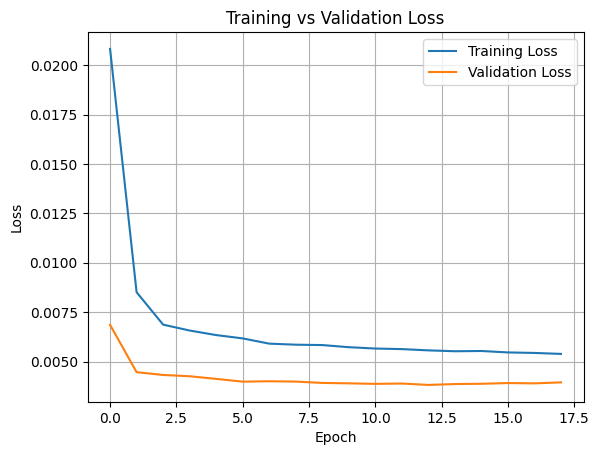

In [25]:
# plot training history, loss vs val_loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Step 6: Evaluate and visualize

y_pred = model.predict(X_test)

y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

from sklearn.metrics import mean_squared_error, r2_score
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"r2: {r2}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
MSE: 52711.40347187814
RMSE: 229.58964147338648
r2: 0.9707313034001629


r2 means the model explains 97% of the varaince in the power output.
RMSE of 229 means that on average the prediction error is around 229 kW.

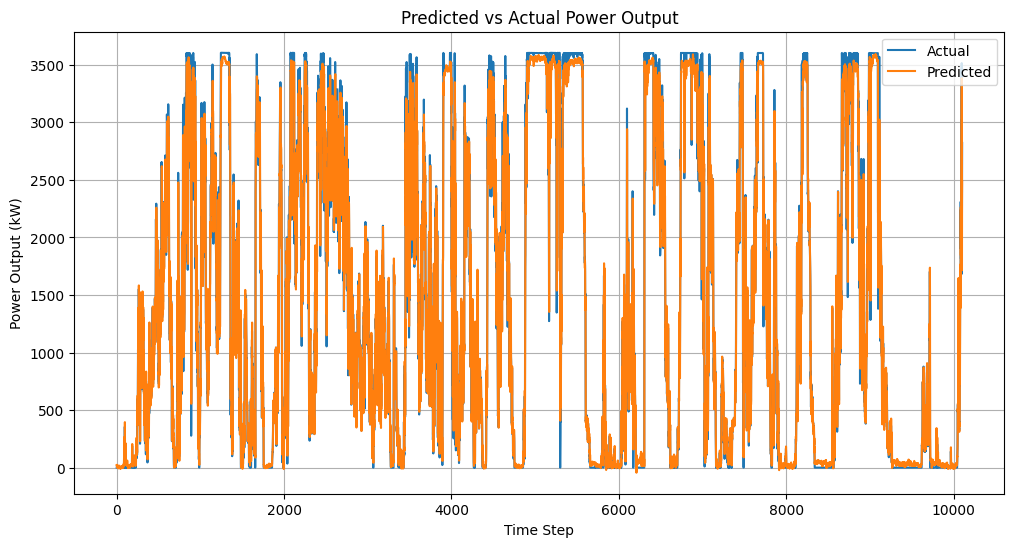

In [27]:
# time series plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Predicted vs Actual Power Output')
plt.xlabel('Time Step')
plt.ylabel('Power Output (kW)')
plt.legend()
plt.grid(True)
plt.show()

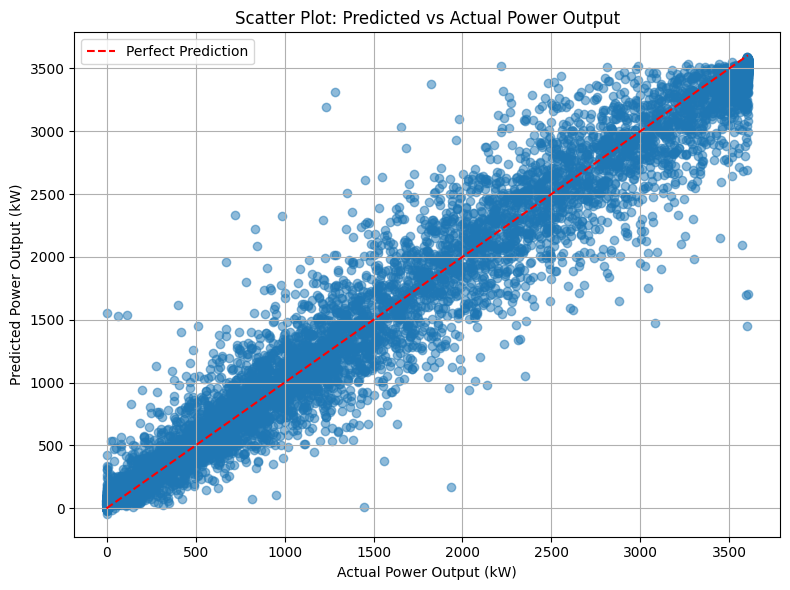

In [28]:
# scatter plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()],
         [y_test_inv.min(), y_test_inv.max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Power Output (kW)')
plt.ylabel('Predicted Power Output (kW)')
plt.title('Scatter Plot: Predicted vs Actual Power Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


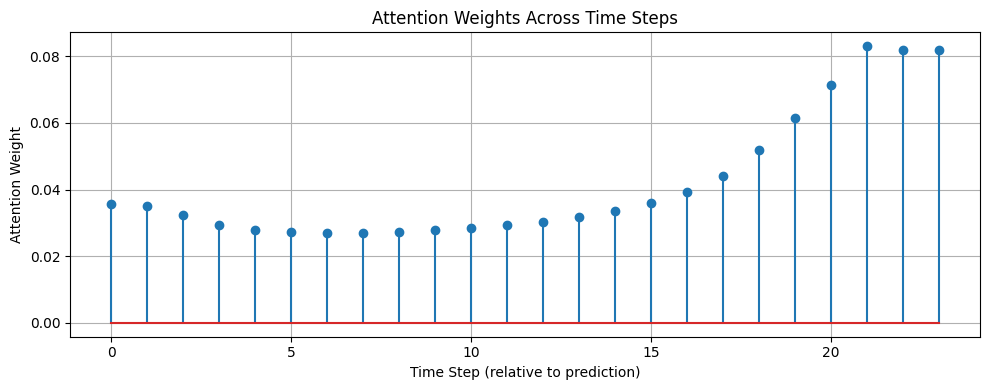

In [31]:
# Create a new model to extract attention weights
attention_output_model = Model(inputs=model.input,
                               outputs=model.get_layer('attention_layer').output[1])  # get attention_weights

sample_idx = 100  # or any sample index
sample_input = X_test[sample_idx:sample_idx+1]  # shape = (1, 24, 3)

attention_weights = attention_output_model.predict(sample_input)  # shape: (1, 24, 50)

mean_attention = np.mean(attention_weights[0], axis=-1)  # shape: (24,)

plt.figure(figsize=(10, 4))
plt.stem(range(seq_length), mean_attention)
plt.title("Attention Weights Across Time Steps")
plt.xlabel("Time Step (relative to prediction)")
plt.ylabel("Attention Weight")
plt.grid(True)
plt.tight_layout()
plt.show()

The model places increasing attention on more recent time steps. This makes sense for a atime series like this example where recent wind speed and power values would have a strong influence on the immediate future.